In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud
from wordcloud import STOPWORDS

In [2]:
import nltk
import regex as re
nltk.download('stopwords')
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Preproccessing Data

In [3]:
data_train = pd.read_csv('/kaggle/input/kuc-hackathon-winter-2018/drugsComTrain_raw.csv')
data_test = pd.read_csv('/kaggle/input/kuc-hackathon-winter-2018/drugsComTest_raw.csv')

In [4]:
# Banyaknya data
print('Jumlah dataset Train:',data_train.shape)
print('Jumlah dataset Test:',data_test.shape)

print('Overview :\n')
data_train.head(5)

Jumlah dataset Train: (161297, 7)
Jumlah dataset Test: (53766, 7)
Overview :



,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [5]:
data = pd.concat([data_train,data_test])
print('Dataset gabungan:',data.shape)

Dataset gabungan: (215063, 7)


In [6]:
# mengatur ulang indeks setelah penggabungan

data.reset_index(inplace=True,drop=True)
data.tail()

,uniqueID,drugName,condition,review,rating,date,usefulCount
215058,159999,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10,13-Sep-14,43
215059,140714,Escitalopram,Anxiety,"""I&#039;ve been taking Lexapro (escitaploprgra...",9,8-Oct-16,11
215060,130945,Levonorgestrel,Birth Control,"""I&#039;m married, 34 years old and I have no ...",8,15-Nov-10,7
215061,47656,Tapentadol,Pain,"""I was prescribed Nucynta for severe neck/shou...",1,28-Nov-11,20
215062,113712,Arthrotec,Sciatica,"""It works!!!""",9,13-Sep-09,46


In [7]:
# memeriksa tipe data dalam kumpulan data
data.dtypes

uniqueID        int64
drugName       object
condition      object
review         object
rating          int64
date           object
usefulCount     int64
dtype: object

In [8]:
# memeriksa nilai Null
data.isnull().any()

uniqueID       False
drugName       False
condition       True
review         False
rating         False
date           False
usefulCount    False
dtype: bool

In [9]:
# memeriksa jumlah null value dan persentase dalam dataset

null_size = data.isnull().sum()['condition']
print('Total null values:',null_size)
data_size = data.shape[0]
print('Persentase null values:',(null_size/data_size)*100)

Total null values: 1194
Persentase null values: 0.5551861547546533


In [10]:
# menghapus baris dengan nilai null

data = data.dropna(axis=0)
print('Size dataset setelah drop NA:',data.shape)

Size dataset setelah drop NA: (213869, 7)


In [11]:
# memeriksa jml kondisi

print('Jumlah kondisi yang berbeda:',data['condition'].unique().shape[0])

Jumlah kondisi yang berbeda: 916


In [12]:
# menghitung jumlah obat untuk setiap kondisi tertentu
val=[]
conditions = dict(data['condition'].value_counts())
for c in list(conditions.keys()):
    val.append(data[data['condition']==c]['drugName'].nunique())

drug_cond = dict(zip(list(conditions.keys()),val))

for index, (key, value) in enumerate(drug_cond.items()):
    if index >= 20:
        break
    print(f"{index + 1}. {key} -> {value}")


1. Birth Control -> 181
2. Depression -> 115
3. Pain -> 219
4. Anxiety -> 81
5. Acne -> 127
6. Bipolar Disorde -> 82
7. Insomnia -> 85
8. Weight Loss -> 22
9. Obesity -> 43
10. ADHD -> 58
11. Diabetes, Type 2 -> 97
12. Emergency Contraception -> 12
13. High Blood Pressure -> 146
14. Vaginal Yeast Infection -> 26
15. Abnormal Uterine Bleeding -> 77
16. Bowel Preparation -> 29
17. Smoking Cessation -> 17
18. ibromyalgia -> 46
19. Migraine -> 60
20. Anxiety and Stress -> 19


In [13]:
# menghilangkan kondisi yang tidak diinginkan pada kolom kondisi pada dataset di atas.
del_index = []
conds =[]
for c in data['condition']:
    if ('helpful' in c) or ('Listed' in c):
        f= list(data[data['condition']==c].index)
        del_index.extend(f)
        conds.append(c)

In [14]:
print('Banyak data sebelum dihapus:',data.shape)
print('Data yang dihapus:',len(conds))


data.drop(del_index,inplace=True)
print('Banyak data setelah dihapus:',data.shape)

Banyak data sebelum dihapus: (213869, 7)
Data yang dihapus: 1763
Banyak data setelah dihapus: (212106, 7)


In [15]:
data.reset_index(inplace=True,drop=True)
data.tail()

,uniqueID,drugName,condition,review,rating,date,usefulCount
212101,159999,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10,13-Sep-14,43
212102,140714,Escitalopram,Anxiety,"""I&#039;ve been taking Lexapro (escitaploprgra...",9,8-Oct-16,11
212103,130945,Levonorgestrel,Birth Control,"""I&#039;m married, 34 years old and I have no ...",8,15-Nov-10,7
212104,47656,Tapentadol,Pain,"""I was prescribed Nucynta for severe neck/shou...",1,28-Nov-11,20
212105,113712,Arthrotec,Sciatica,"""It works!!!""",9,13-Sep-09,46


In [16]:
# Cleaning func

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [17]:
# Cleaning

def preprocess_text(text_data):

    text_data = decontracted(text_data)

    text_data = text_data.replace('\n',' ')
    text_data = text_data.replace('\r',' ')
    text_data = text_data.replace('\t',' ')
    text_data = text_data.replace('-',' ')
    text_data = text_data.replace("/",' ')
    text_data = text_data.replace(">",' ')
    text_data = text_data.replace('"',' ')
    text_data = text_data.replace('?',' ')
    return text_data

In [18]:
# Stopword

stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

# menghapus 'no' dari daftar stopwords karena pentingnya 'side effects' dan 'no side effects' dalam kolom review
stop_words.remove('no')

# Stemming
def nlp_preprocessing(review):
    '''untuk menghapus digit, spasi berlebih, kata2 yg tdk diingankan dan mengkonversi ke huruf kecil lalu melakukan stemming'''

    if type(review) is not int:
        string = ""
        review = preprocess_text(review)
        review = re.sub('[^a-zA-Z]', ' ', review)

        review = re.sub('\s+',' ', review)

        review = review.lower()

        for word in review.split():

            if not word in stop_words:
                word = stemmer.stem(word)
                string += word + " "

        return string

In [19]:
# Kolom baru 'clean_review'
data['clean_review'] = data['review'].apply(nlp_preprocessing)

In [20]:
# Lower case kolom 'drugName'

data['drugName'] = data['drugName'].apply(lambda x:x.lower())

In [21]:
# Lower case kolom 'condition'
data['condition'] = data['condition'].apply(lambda x:x.lower())

In [22]:
drop_kolom = ['rating', 'date', 'uniqueID']
data = data.drop(columns=drop_kolom)
data.head()

,drugName,condition,review,usefulCount,clean_review
0,valsartan,left ventricular dysfunction,"""It has no side effect, I take it in combinati...",27,no side effect take combin bystol mg fish oil
1,guanfacine,adhd,"""My son is halfway through his fourth week of ...",192,son halfway fourth week intuniv becam concern ...
2,lybrel,birth control,"""I used to take another oral contraceptive, wh...",17,use take anoth oral contracept pill cycl happi...
3,ortho evra,birth control,"""This is my first time using any form of birth...",10,first time use form birth control glad went pa...
4,buprenorphine / naloxone,opiate dependence,"""Suboxone has completely turned my life around...",37,suboxon complet turn life around feel healthie...


In [23]:
data.shape
data.head()

,drugName,condition,review,usefulCount,clean_review
0,valsartan,left ventricular dysfunction,"""It has no side effect, I take it in combinati...",27,no side effect take combin bystol mg fish oil
1,guanfacine,adhd,"""My son is halfway through his fourth week of ...",192,son halfway fourth week intuniv becam concern ...
2,lybrel,birth control,"""I used to take another oral contraceptive, wh...",17,use take anoth oral contracept pill cycl happi...
3,ortho evra,birth control,"""This is my first time using any form of birth...",10,first time use form birth control glad went pa...
4,buprenorphine / naloxone,opiate dependence,"""Suboxone has completely turned my life around...",37,suboxon complet turn life around feel healthie...


In [24]:
# simpan data preprocessing
data.to_csv('data_preprocessing.csv',index=False)

## Sentiment Analysis 'Vader Sentiment'

In [25]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [26]:
data = pd.read_csv('/kaggle/input/preprocess/data_preprocessing.csv')

print(data.shape)
data.head()

(212106, 8)


,uniqueID,drugName,condition,review,rating,date,usefulCount,clean_review
0,206461,valsartan,left ventricular dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,no side effect take combin bystol mg fish oil
1,95260,guanfacine,adhd,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,son halfway fourth week intuniv becam concern ...
2,92703,lybrel,birth control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,use take anoth oral contracept pill cycl happi...
3,138000,ortho evra,birth control,"""This is my first time using any form of birth...",8,3-Nov-15,10,first time use form birth control glad went pa...
4,35696,buprenorphine / naloxone,opiate dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,suboxon complet turn life around feel healthie...


In [27]:
import spacy
from tqdm import tqdm
nlp = spacy.load('en_core_web_lg')

In [28]:
# aspek komponen

drugs_list = data['drugName'].unique()
print(drugs_list)

['valsartan' 'guanfacine' 'lybrel' ... 'pegaptanib' 'fibercon'
 'allergy dn pe']


In [29]:
# menambahkan kolom baru yang berisi skor sentimen untuk kolom clean_review
data['clean_review'] = data['clean_review'].astype(str)

from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
data['skor_sentimen'] = [sid.polarity_scores(v)['compound'] for v in data['clean_review']]
data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,clean_review,skor_sentimen
0,206461,valsartan,left ventricular dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,no side effect take combin bystol mg fish oil,-0.2960
1,95260,guanfacine,adhd,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,son halfway fourth week intuniv becam concern ...,0.6929
2,92703,lybrel,birth control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,use take anoth oral contracept pill cycl happi...,0.2732
3,138000,ortho evra,birth control,"""This is my first time using any form of birth...",8,3-Nov-15,10,first time use form birth control glad went pa...,0.1027
4,35696,buprenorphine / naloxone,opiate dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,suboxon complet turn life around feel healthie...,0.8934


In [30]:
# klasifikasi sentimen positif , negatif, dan neutral
int_sent = []
for sent in data['skor_sentimen']:
    if sent < 0:
        int_sent.append(0)
    elif sent > 0:
        int_sent.append(1)
    else :
        int_sent.append('neu')
data['sentimen'] = int_sent
data.tail(20)

,uniqueID,drugName,condition,review,rating,date,usefulCount,clean_review,skor_sentimen,sentimen
212086,110775,imodium,"diarrhea, acute","""I&#039;ve had diarrhoea for 3 days now with m...",8,28-Mar-16,6,diarrhoea day minim sleep constant abdomin pai...,-0.8225,0
212087,199982,varenicline,smoking cessation,"""Horrible! I have been a smoker for 14 years. ...",1,27-Jan-16,12,horribl smoker year tri chantix dream bad slee...,-0.9300,0
212088,127066,metoclopramide,gerd,"""Glad to have it available to me.""",8,20-Apr-09,8,glad avail,0.4588,1
212089,153929,vivitrol,opiate dependence,"""After 16 years of opioid and heroin addiction...",8,18-Jul-16,35,year opioid heroin addict tri everyth methadon...,-0.8957,0
212090,4705,belviq,weight loss,"""I have had the worst experience with this pil...",1,2-May-15,16,worst experi pill took one pill head start bla...,-0.9035,0
212091,151266,chantix,smoking cessation,"""I took chantix a little over a month. It made...",1,11-Nov-17,2,took chantix littl month made psychot split ta...,0.5267,1
212092,212844,sofosbuvir / velpatasvir,hepatitis c,"""After first month of taking Epclusa, I am und...",8,13-Apr-17,12,first month take epclusa undetect,0.0000,neu
212093,204390,buspar,anxiety,"""Diagnosed with general anxiety disorder. Wou...",10,25-Feb-16,123,diagnos general anxieti disord would obsess th...,-0.8519,0
212094,76895,lorcaserin,obesity,"""It didn&#039;t help me at all. I craved choco...",2,15-Aug-15,8,help crave chocol time worth month,0.5574,1
212095,194823,levetiracetam,epilepsy,"""I now suffer from excessive tiredness and lac...",8,21-Jul-16,5,suffer excess tired lack energi consult gp alt...,-0.8271,0


In [31]:
data = data[data['sentimen'] != 'neu']

data.reset_index(inplace=True,drop=True)
data.tail()

,uniqueID,drugName,condition,review,rating,date,usefulCount,clean_review,skor_sentimen,sentimen
202778,123432,apri,birth control,"""I started taking Apri about 7 months ago. My ...",9,25-Aug-10,18,start take apri month ago breat got notic larg...,0.7964,1
202779,159999,tamoxifen,"breast cancer, prevention","""I have taken Tamoxifen for 5 years. Side effe...",10,13-Sep-14,43,taken tamoxifen year side effect sever sweat d...,-0.8750,0
202780,140714,escitalopram,anxiety,"""I&#039;ve been taking Lexapro (escitaploprgra...",9,8-Oct-16,11,take lexapro escitaploprgram sinc februari fir...,0.7845,1
202781,130945,levonorgestrel,birth control,"""I&#039;m married, 34 years old and I have no ...",8,15-Nov-10,7,marri year old no kid take pill hassl decid ge...,-0.9501,0
202782,47656,tapentadol,pain,"""I was prescribed Nucynta for severe neck/shou...",1,28-Nov-11,20,prescrib nucynta sever neck shoulder pain take...,-0.8519,0


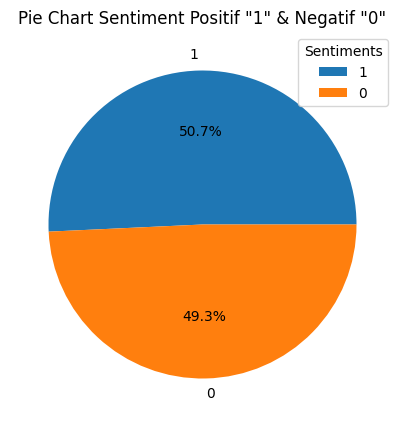

In [32]:
import matplotlib.pyplot as plt

sent_counts = dict(data['sentimen'].value_counts())
count = list(sent_counts.values())
labels = list(sent_counts.keys())
plt.figure(figsize=(10,5))
plt.pie(count,labels=labels, autopct='%1.1f%%')
plt.title('Pie Chart Sentiment Positif "1" & Negatif "0"')
plt.legend(title='Sentiments')
plt.show()

In [33]:
## Under Sampling
# class_counts = data['int_sent'].value_counts()
# class_major = class_counts.max()
# pd.concat([data[data['int_sent'] == label].sample(class_major, replace=True) for label in class_counts.index])

In [34]:
data.to_csv('final_data.csv',index=False)

## Modelling

In [35]:
data =  pd.read_csv('final_data.csv')
data.tail()

,uniqueID,drugName,condition,review,rating,date,usefulCount,clean_review,skor_sentimen,sentimen
202778,123432,apri,birth control,"""I started taking Apri about 7 months ago. My ...",9,25-Aug-10,18,start take apri month ago breat got notic larg...,0.7964,1
202779,159999,tamoxifen,"breast cancer, prevention","""I have taken Tamoxifen for 5 years. Side effe...",10,13-Sep-14,43,taken tamoxifen year side effect sever sweat d...,-0.8750,0
202780,140714,escitalopram,anxiety,"""I&#039;ve been taking Lexapro (escitaploprgra...",9,8-Oct-16,11,take lexapro escitaploprgram sinc februari fir...,0.7845,1
202781,130945,levonorgestrel,birth control,"""I&#039;m married, 34 years old and I have no ...",8,15-Nov-10,7,marri year old no kid take pill hassl decid ge...,-0.9501,0
202782,47656,tapentadol,pain,"""I was prescribed Nucynta for severe neck/shou...",1,28-Nov-11,20,prescrib nucynta sever neck shoulder pain take...,-0.8519,0


In [36]:
# encode kolom condition dan drugName

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data['condition'] = label_encoder.fit_transform(data['condition'])
data['drugName'] = label_encoder.fit_transform(data['drugName'])

## Word2Vec

In [37]:
from gensim.models import Word2Vec
from tqdm import tqdm
sentences = []
for r in tqdm(data['clean_review']):
    sentences.append(r.split())
model_W2V = Word2Vec(sentences,vector_size=300,workers=12,min_count=1)
model_W2V.save('word2vec.bin')
model_W2V = Word2Vec.load('word2vec.bin')

100%|██████████| 202783/202783 [00:02<00:00, 82208.04it/s]


In [38]:
def create_w2v(df,feature):
    w2v_vector =[]
    for review in df[feature]:
        vector = np.zeros(300)

        for word in review.split():
            if word in model_W2V.wv.key_to_index:
                vector += model_W2V.wv[word]

        w2v_vector.append(vector)
    w2v_vector = np.array(w2v_vector)
    return w2v_vector

In [39]:
x = create_w2v(data,'clean_review')
x.shape

(202783, 300)

In [40]:
y = data['sentimen'].values

In [41]:
## Over Sampling 

# from imblearn.over_sampling import RandomOverSampler

# # Inisialisasi RandomOverSampler
# ros = RandomOverSampler(random_state=0)
# # Melakukan oversampling pada data 
# x_resampled, y_resampled = ros.fit_resample(x, y)


## Splitting Data X dan Y

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x,y,stratify=y,test_size=0.20,random_state=42)

In [43]:
from xgboost import XGBClassifier
model_XGB = XGBClassifier(n_estimators=5000,subsample=0.8,max_depth=7, colsample_bytree = 0.8, learning_rate = 0.01)
model_XGB.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=5000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [44]:
from sklearn.metrics import accuracy_score

# Evaluasi performa model
y_pred = model_XGB.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Akurasi model: {:.2f}%".format(accuracy * 100))

# Evaluasi training
y_pred_tr = model_XGB.predict(X_train)
accuracy_train= accuracy_score(y_train, y_pred_tr)
print("Akurasi training: {:.2f}%".format(accuracy_train * 100))

Akurasi model: 90.83%
Akurasi training: 98.72%


In [45]:
from sklearn.metrics import classification_report
# Tampilkan classification report
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91     19979
           1       0.91      0.91      0.91     20578

    accuracy                           0.91     40557
   macro avg       0.91      0.91      0.91     40557
weighted avg       0.91      0.91      0.91     40557



## Simpan Model XGB

In [46]:
import pickle
# Simpan model ke file menggunakan pickle
with open('model_xgb.pkl', 'wb') as file:
    pickle.dump(model_XGB, file)

In [47]:
def create_new_w2v(review,model):
    '''This function creates the w2v embeddings for the cleaned reviews passed'''
    w2v_vector =[]
    vector = np.zeros(300)
    for word in review.split():
        if word in model.wv.key_to_index:
            vector += model.wv[word]
    
    w2v_vector.append(vector)
    w2v_vector = np.array(w2v_vector)
    return w2v_vector

In [48]:
import nltk

model_W2V = Word2Vec.load('word2vec.bin')
with open('model_xgb.pkl', 'rb') as file:
    model_XGB = pickle.load(file)
    
def sentiment_predictor(input):
    input = nlp_preprocessing(input)
    transformed_input = create_new_w2v(input,model_W2V)
    prediction = model_XGB.predict(transformed_input)
    return prediction[0]

review = "It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"
# review = "I started taking Apri about 7 months ago. My breats got noticeably larger within the first few weeks and I gained about 10 pounds, but I&#039;m a thin girl anyway so I gladly take on the extra few pounds and curves. I got prescribed this birth control because of my ovarian cysts and since I have not had any problems with them. They&#039;ve been unnoticeable and my cramps don&#039;t even exist anymore. I love Apri and it&#039;s affordable. Just what I need in this economic clash."
sentiment_predictor(review)

0

In [49]:
#import pickle
## Load model dari file
# with open('model_xgb.pkl', 'rb') as file:
#     model_XGB = pickle.load(file)

## Recommendation

In [50]:
def userful_count(data,feature):
    max_value = data[feature].max()
    min_value = data[feature].min()
    data[feature] = (data[feature] - min_value) / (max_value - min_value)
    return data

In [51]:
data =  pd.read_csv('final_data.csv')
len(data)

202783

In [52]:
data = userful_count(data,'usefulCount')
data['recommendation_score'] = data['usefulCount'] * data['sentimen']

data.head(10)

,uniqueID,drugName,condition,review,rating,date,usefulCount,clean_review,skor_sentimen,sentimen,recommendation_score
0,206461,valsartan,left ventricular dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,0.020914,no side effect take combin bystol mg fish oil,-0.2960,0,0.000000
1,95260,guanfacine,adhd,"""My son is halfway through his fourth week of ...",8,27-Apr-10,0.148722,son halfway fourth week intuniv becam concern ...,0.6929,1,0.148722
2,92703,lybrel,birth control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,0.013168,use take anoth oral contracept pill cycl happi...,0.2732,1,0.013168
3,138000,ortho evra,birth control,"""This is my first time using any form of birth...",8,3-Nov-15,0.007746,first time use form birth control glad went pa...,0.1027,1,0.007746
4,35696,buprenorphine / naloxone,opiate dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,0.028660,suboxon complet turn life around feel healthie...,0.8934,1,0.028660
5,155963,cialis,benign prostatic hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,28-Nov-15,0.033308,nd day mg start work rock hard erect howev exp...,-0.1531,0,0.000000
6,102654,aripiprazole,bipolar disorde,"""Abilify changed my life. There is hope. I was...",10,14-Mar-15,0.024787,abilifi chang life hope zoloft clonidin first ...,-0.8442,0,0.000000
7,74811,keppra,epilepsy,""" I Ve had nothing but problems with the Kepp...",1,9-Aug-16,0.008521,noth problem keppera constant shake arm amp le...,-0.6808,0,0.000000
8,48928,ethinyl estradiol / levonorgestrel,birth control,"""I had been on the pill for many years. When m...",8,8-Dec-16,0.000775,pill mani year doctor chang rx chateal effect ...,0.8481,1,0.000775
9,29607,topiramate,migraine prevention,"""I have been on this medication almost two wee...",9,1-Jan-15,0.014717,medic almost two week start mg work way mg cur...,0.1280,1,0.014717


In [53]:
# Save data dengan skor rekomendasi
data.to_csv('recommendation_data.csv',index=False)

In [54]:
def recommend(condition):
    data = pd.read_csv('recommendation_data.csv')
    select = data[data['condition']==condition]
    drug_count = select['drugName'].nunique()
    select['recommendation_score'] = select['recommendation_score']/drug_count
    group_drug = select.groupby(['drugName']).agg({'recommendation_score':['sum']})
    group_drug = group_drug[('recommendation_score', 'sum')].sort_values(ascending=False)
    drug_score = dict(group_drug)
    if len(drug_score)>5:
        print('5 Obat Terbaik untuk kondisi ini : {0}'.format(condition.upper()))
        for i in list(drug_score.keys())[0:5]:
            print('->',i)

    else:
        print('Obat Top untuk kondisi ini : {0}'.format(condition.upper()))
        for i in drug_score.keys():
            print('->',i)

In [55]:
recommend('adhd')

5 Obat Terbaik untuk kondisi ini : ADHD
-> lisdexamfetamine
-> vyvanse
-> methylphenidate
-> amphetamine / dextroamphetamine
-> adderall
